这一章我们将用支持向量机构造一个垃圾分类器

## 1. Support Vector Machines

### 1.1 example dataset 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat

In [5]:
data1 = loadmat('ex6data1.mat')
X = data1['X']
y = data1['y']
X.shape, y.shape

((51, 2), (51, 1))

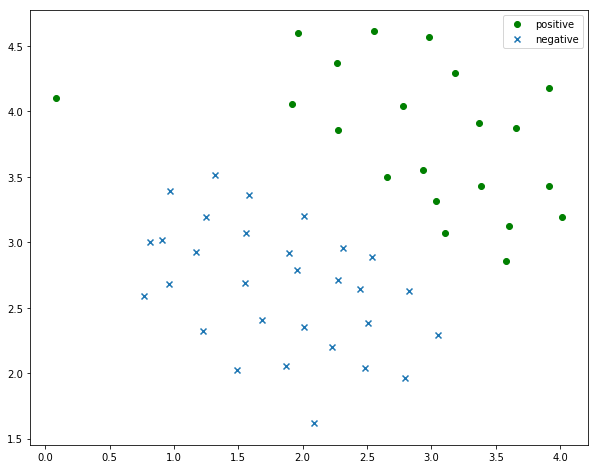

In [18]:
data = pd.DataFrame(X, columns=['X1', 'X2'])
data['y'] = y

positive = X[data.y == 1]
negative = X[data.y == 0]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(positive.X1, positive.X2, c='g', label='positive' )
ax.scatter(negative.X1, negative.X2, marker='x', label='negative')
plt.legend(loc='best')
plt.show()

基本上可以看出边界应该是一条直线，下面就可以利用SVM进行分类了

In [19]:
from sklearn import svm

# 构造线性分类器
svc = svm.LinearSVC(C=1, loss='hinge', max_iter=1000)
svc

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

先尝试 C=1 的时候分类效果

In [21]:
svc.fit(data[['X1', 'X2']], data['y'])
svc.score(data[['X1', 'X2']], data['y'])

0.98039215686274506

尝试 C=100 的情况

In [22]:
svc2 = svm.LinearSVC(C=100, loss='hinge', max_iter=1000)
svc2.fit(data[['X1', 'X2']], data['y'])
svc2.score(data[['X1', 'X2']], data['y'])

1.0

查看类别预测的置信水平

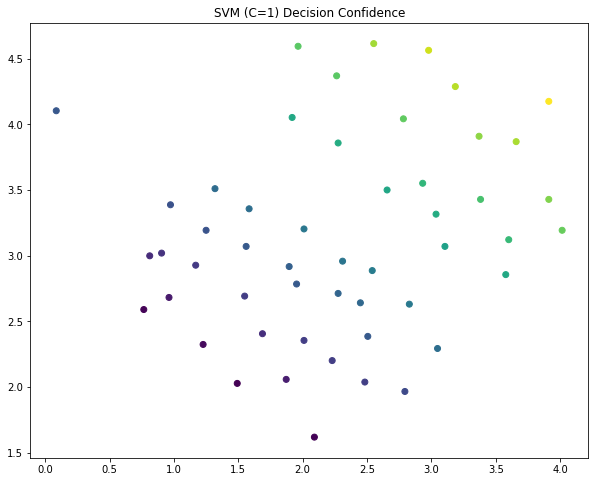

In [27]:
data['SVM 1 Confidence'] = svc.decision_function(data[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(data['X1'], data['X2'], c=data['SVM 1 Confidence'])
ax.set_title('SVM (C=1) Decision Confidence')
plt.show()

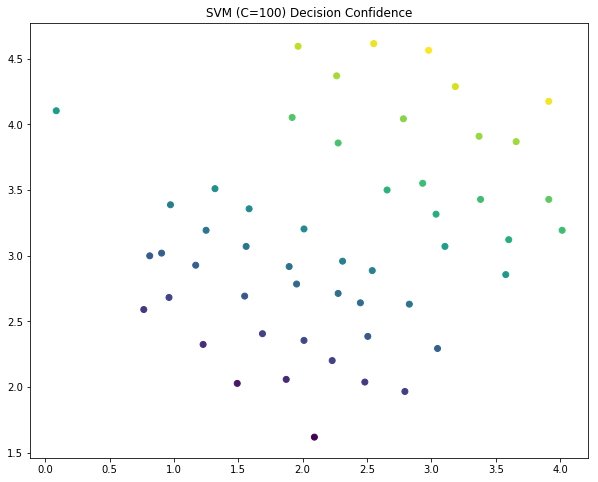

In [29]:
data['SVM 2 Confidence'] = svc2.decision_function(data[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(data['X1'], data['X2'], c=data['SVM 2 Confidence'])
ax.set_title('SVM (C=100) Decision Confidence')
plt.show()

### 1.2 SVM with Gaussian Kernals

#### 1.2.1 gaussian kernel

$K=exp\left( -\dfrac {\sum ^{n}_{k=1}\left( x^{i}_{k}-x^{j}_{k}\right) ^{2}}{2\sigma ^{2}}\right)$

In [30]:
def gaussian_kernel(x1, x2, sigma):
    return np.exp(-(np.sum((x1-x2) ** 2))/(2 * (sigma ** 2)))

In [33]:
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2

gaussian_kernel(x1, x2, sigma)

0.32465246735834974

#### 1.2.2 exanple dataset 2

查看第二个数据集

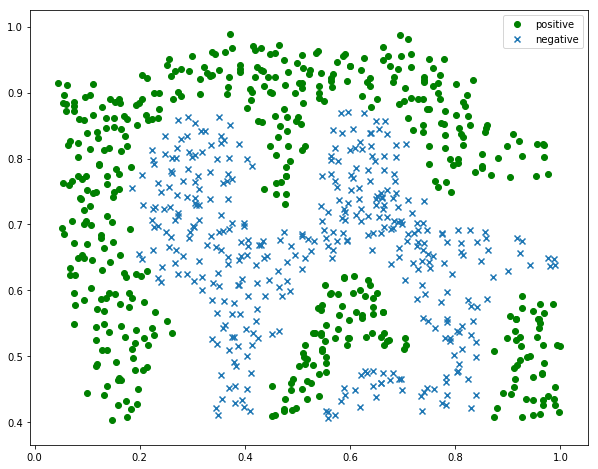

In [35]:
data2 = loadmat('ex6data2.mat')

data = pd.DataFrame(data2['X'], columns=['X1', 'X2'])
data['y'] = data2['y']

positive = data[data.y == 1]
negative = data[data.y == 0]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(positive.X1, positive.X2, c='g', label='positive')
ax.scatter(negative.X1, negative.X2, marker='x', label='negative')
plt.legend(loc='best')
plt.show()

这个边界明显的不规则了很多，不是线性的了，我们将使用内建的RBF内核构造支持向量机分类器

In [36]:
svc = svm.SVC(C=100, gamma=10, probability=True)
svc

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [38]:
svc.fit(data[['X1', 'X2']], data['y'])
svc.score(data[['X1', 'X2']], data['y'])

0.9698725376593279

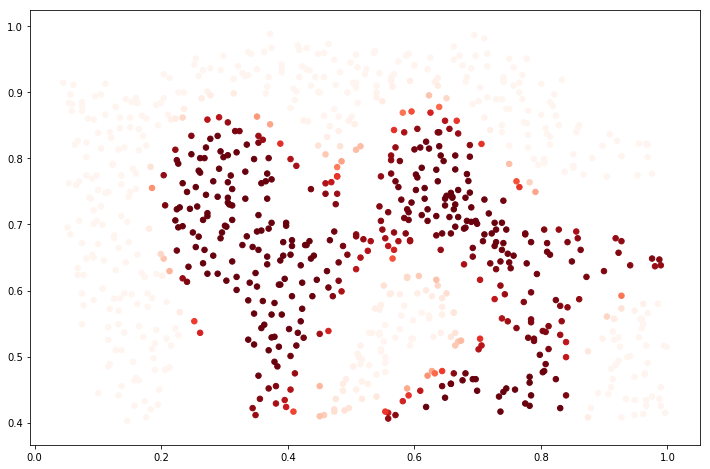

In [40]:
data['Probability'] = svc.predict_proba(data[['X1', 'X2']])

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['X1'], data['X2'], s=30, c=data['Probability'], cmap='Reds')
plt.show()

分类效果相当好

#### 1.2.3 example dataset 3

In [45]:
data3 = loadmat('ex6data3.mat')

X = data3['X']
Xval = data3['Xval']
y = data3['y'].ravel()
yval = data3['yval'].ravel()

C_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
gamma_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]

best_score = 0
best_params = {'C': None, 'gamma': None}

for C in C_values:
    for gamma in gamma_values:
        svc = svm.SVC(C=C, gamma=gamma)
        svc.fit(X, y)
        score = svc.score(Xval, yval)
        
        if score > best_score:
            best_score = score
            best_params['C'] = C
            best_params['gamma'] = gamma

best_score, best_params

(0.96499999999999997, {'C': 0.3, 'gamma': 100})

## 2. Spam Classification

对于垃圾邮件而言，首先要将每一个email映射到特征向量空间

### 2.1 preprocessing emails

In [49]:
spam_train = loadmat('spamTrain.mat')
spam_test = loadmat('spamTest.mat')

spam_train

{'X': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Nov 13 14:27:25 2011',
 '__version__': '1.0',
 'y': array([[1],
        [1],
        [0],
        ..., 
        [1],
        [0],
        [0]], dtype=uint8)}

In [50]:
X = spam_train['X']
Xtest = spam_test['Xtest']
y = spam_train['y'].ravel()
ytest = spam_test['ytest'].ravel()

X.shape, y.shape, Xtest.shape, ytest.shape

((4000, 1899), (4000,), (1000, 1899), (1000,))

1899对应着1899个单词，属性0表示未出现，属性1表示出现

### 2.2 extracting features from emails

In [52]:
svc = svm.SVC()
svc.fit(X, y)
print('Training accuracy={0}%'.format(np.round(svc.score(X, y) * 100, 2)))

Training accuracy=94.4%


In [53]:
print('Test accuracy = {0}%'.format(np.round(svc.score(Xtest, ytest) * 100, 2)))

Test accuracy = 95.3%


可以看出精度很高！

## 附加任务：建议尝试高度优化的SVM工具箱 LIBSVM